# Unsupervised Learning on Scientific Abstracts
_This project applies unsupervised machine learning techniques to a dataset of **5,000 scientific abstracts**, with the goal of extracting meaningful patterns and topics from unstructured text data. The process includes **natural language processing**, **feature engineering**, **dimensionality reduction**, and **clustering**._

_We ultimately cluster the abstracts using **K-Means** and visualize the clusters using **word clouds** and **3D scatter plots**._


## Data : Sample of 5k ArXiv Paper Abstracts
For this project we will work on a dataset of 5k paper abstracts uploaded to the online scholarly article repository [arXiv](https://arxiv.org/). The .csv is bundled with this project titled "abstracts_5k.csv". Each row corresponds to a paper and contains the following fields:

1. `id` : Unique ID assigned to each submission on arXiv formatted as `YYMM.NNNNN` (YY - two characters for year, MM - two characters for month, NNNNN - upto 5 characters for serial number of submission). Older submissions have the following format: `subject/YYMMNNN` e.g. `cs/0511035`

2. `submitter`: Name of the user uploading the paper

3. `authors`: Names of the authors

4. `comments`: Comments made by the submitter about the paper during submission

5. `journal-ref`: Bibliographic reference to the article if it has been published in a journal

6. `doi`: Digital Object Identifier(s) of the article

7. `abstract`: Contents of the paper's abstract

8. `report-no`: Publication number assigned by the author's institution

9. `version`: List of versions of the paper on arXiv

As you can see, we have almost all metadata for each research paper submission EXCEPT for which subject it belongs to. Our goal with this project will be to use unsupervised learning to **discover what subjects are prevalent in the data using the contents of each paper's abstract using K-Means clustering**.

Our pipeline will have the following stages:

* A. **Text Processing**: Clean up of the abstracts text data using the [nltk](http://www.nltk.org/genindex.html) package; this stage is identical to the previous homework and you are allowed to reuse your functions here.
* B. **Feature Construction**: Constructing feature vectors for our abstracts
* C. **Clustering**: Cluster the abstracts using the feature vectors
* D. **Visualization**: Visualize the obtained clusters
* E. **Findings: Answering Key Questions**: Written explanation of results and further improvements.

Since we are working with text data, we will be relying heavily on `nltk` and `sklearn`. For visualization, we will use a Python package called `WordCloud` in addition to `matplotlib`. Some of the packages have been imported below, rest will be installed via pip and imported later.



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sklearn
import re
import string
%matplotlib widget

from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [4]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("punkt_tab")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mnusa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mnusa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\mnusa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mnusa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mnusa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mnusa\AppData\Roaming\nltk_data...
[nltk_data]   Package average

## A. Text Processing

Our focus will primarily be on textual data encoded in the paper abstracts, hence we will write a string of functions to process text data. Each abstract is a raw string of characters, and our desired output from this stage will be a list of tokens that satifies the following criteria:

1. All tokens are in lower case
2. Order of tokens is preserved
3. Tokens are lemmatized: ignore exceptions thrown during the lemmatization process with nltk
4. Punctuations are stripped from all tokens
5. URLs must be completely removed
6. <mark>Inline LaTeX equations must be removed</mark> (character sequences enclosed within single '$' characters)
7. <mark>LaTeX Text Decorations must be removed</mark> (e.g. "\textit{euler}" becomes "euler", and "\underline{data science}" becomes "data science")

### Cleaning Text I:

In [4]:
# Convert part of speech tag from nltk.pos_tag to word net compatible format
# Simple mapping based on first letter of return tag to make grading consistent
# Everything else will be considered noun 'n'
posMapping = {
# "First_Letter by nltk.pos_tag":"POS_for_lemmatizer"
    "N":'n',
    "V":'v',
    "J":'a',
    "R":'r'
}

def process(text, lemmatizer=nltk.WordNetLemmatizer()):

    """ 
    Normalizes case and handles punctuation

    Parameters
    ----------
    text: str: 
        raw text
    lemmatizer: nltk.WordNetLemmatizer() 
        an instance of a class implementing the lemmatize() method
        (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    
    Returns
    -------
    list(str)
        tokenized text
    """

    # Step 1: Convert to lower case
    text = text.lower()
    
    # Step 2: Remove URLs
    text = re.sub(r'http:/\S+|www\S+|https:/\S+', '', text, flags=re.MULTILINE)
    
    # Step 3: Remove inline LaTeX equations
    text = re.sub(r'\$.*?\$', '', text)  # Strict match for $...$

    # Step 4: Remove LaTeX text decorations (e.g., \textit{}, \underline{})
    text = re.sub(r'\\text\w*{(.*?)}', r'\1', text)

    # Step 5: Replace hyphens with spaces for compound words
    text = re.sub(r'[-]', ' ', text)

    # Step 6: Remove or handle punctuation
    # Handle specific punctuation cases and remove others
    text = re.sub(r"'s", '', text)  # Remove 's
    text = re.sub(r"'", '', text)  # Replace other apostrophes with ''
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) # Replace any punctuation with a space
    
    # Step 7: Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Step 8: Lemmatize tokens based on POS
    lemmatized_tokens = []
    pos_tags = nltk.pos_tag(tokens)  # Get POS tags
    
    for word, tag in pos_tags:
        # Get the first letter of the POS tag
        first_letter = tag[0]
        pos = posMapping.get(first_letter, 'n')  # Default to noun if not found
        try:
            lemmatized_word = lemmatizer.lemmatize(word, pos=pos)
            lemmatized_tokens.append(lemmatized_word)
        except Exception:
            continue  # Ignore words that cannot be lemmatized

    return lemmatized_tokens

We will test the `process()` function at the bottom of the following code cell.

In [5]:
input_1 = " Two-dimensional (2D) layered transition metal dichalcogenides \
              (TMDs) have\nemerged as promising materials for electronic, optoelectronic,\
               and valleytronic\napplications."

print(process(input_1))
# ['two', 'dimensional', '2d', 'layered', 'transition', 'metal', 'dichalcogenides',
#  'tmds', 'have', 'emerge', 'a', 'promising', 'material', 'for', 'electronic',
#  'optoelectronic', 'and', 'valleytronic', 'application']

input_2 = "  We solved analytically viscous two-dimensional (2D) fluid equations\
               for\naccretion and outflows in spherical polar coordinates ($r, \\theta, \\phi$)\
               and\nobtained explicitly flow variables in $r-$ and $\\theta -$directions\
               around\nblack holes (BHs)."

print(process(input_2))
# ['we', 'solve', 'analytically', 'viscous', 'two', 'dimensional', '2d', 'fluid',\
#  'equation', 'for', 'accretion', 'and', 'outflow', 'in', 'spherical', 'polar',\
#  'coordinate', 'and', 'obtain', 'explicitly', 'flow', 'variable', 'in',\
#  'direction', 'around', 'black', 'hole', 'bhs']

input_3 = "'  The pumping intensity (I) dependence of the photoluminescence (PL) spectra of\n\
            perfectly laterally two-dimensionally ordered SiGe quantum dots on Si(001)\n\
            substrates was studied. The PL results from recombinations of holes localized\
            \nin the SiGe quantum dots and electrons localized due to the strain field\
            in the\nsurrounding Si matrix. At approximately \
            I>3W/cm^2,\nadditional bands with a nearly quadratic \
            I dependence appear in the PL spectra "

print(process(input_3))
#['the', 'pump', 'intensity', 'i', 'dependence', 'of', 'the', 'photoluminescence',\
#  'pl', 'spectrum', 'of', 'perfectly', 'laterally', 'two', 'dimensionally', 'order',\
#  'sige', 'quantum', 'dot', 'on', 'si001', 'substrate', 'be', 'study', 'the', 'pl',\
#  'result', 'from', 'recombination', 'of', 'hole', 'localize', 'in', 'the', 'sige',\
#  'quantum', 'dot', 'and', 'electron', 'localize', 'due', 'to', 'the', 'strain', 'field',\
#  'in', 'the', 'surround', 'si', 'matrix', 'at', 'approximately', 'i3wcm2', 'additional',\
#  'band', 'with', 'a', 'nearly', 'quadratic', 'i', 'dependence', 'appear', 'in', 'the',\
#  'pl', 'spectrum']

# [Tests Start Here]

input_4 = "This paper proposes a new method $E = mc^2$ using \\textit{neural networks} for classification. Visit https://example.com for details."
print(process(input_4))
# ['this', 'paper', 'propose', 'a', 'new', 'method', 'use', 'neural', 'network', 'for', 'classification', 'visit', 'for', 'detail']

input_5 = "The self-driving car's performance is evaluated using a state-of-the-art model. Check results at www.results.com."
print(process(input_5))
# ['the', 'self', 'drive', 'car', 'performance', 'be', 'evaluate', 'use', 'a', 'state', 'of', 'the', 'art', 'model', 'check', 'result', 'at']

input_6 = "We analyze high-frequency data using \\textbf{advanced} algorithms. Visit http://example.org for implementation details."
print(process(input_6))
# ['we', 'analyze', 'high', 'frequency', 'data', 'use', 'advanced', 'algorithms', 'visit', 'for', 'implementation', 'detail']

input_7 = "This is a test - an example of punctuations! Can this process handle it?"
print(process(input_7))

# [Your Tests End Here]


['two', 'dimensional', '2d', 'layered', 'transition', 'metal', 'dichalcogenides', 'tmds', 'have', 'emerge', 'a', 'promising', 'material', 'for', 'electronic', 'optoelectronic', 'and', 'valleytronic', 'application']
['we', 'solve', 'analytically', 'viscous', 'two', 'dimensional', '2d', 'fluid', 'equation', 'for', 'accretion', 'and', 'outflow', 'in', 'spherical', 'polar', 'coordinate', 'and', 'obtain', 'explicitly', 'flow', 'variable', 'in', 'and', 'direction', 'around', 'black', 'hole', 'bhs']
['the', 'pump', 'intensity', 'i', 'dependence', 'of', 'the', 'photoluminescence', 'pl', 'spectrum', 'of', 'perfectly', 'laterally', 'two', 'dimensionally', 'order', 'sige', 'quantum', 'dot', 'on', 'si001', 'substrate', 'be', 'study', 'the', 'pl', 'result', 'from', 'recombination', 'of', 'hole', 'localize', 'in', 'the', 'sige', 'quantum', 'dot', 'and', 'electron', 'localize', 'due', 'to', 'the', 'strain', 'field', 'in', 'the', 'surround', 'si', 'matrix', 'at', 'approximately', 'i3wcm2', 'additional

### Cleaning Text II:

It's time now to load our dataset:

In [6]:
abstracts = pd.read_csv("./abstracts_5k.csv", index_col=0)
abstracts.head()

id                    submitter  \
0         0804.0629                  Boaz Tsaban   
1         0908.3353      Fabio Giuseppe Pusateri   
2  quant-ph/0304129                     Mardoyan   
3        1605.06142               Nadine Fischer   
4  cond-mat/0602014  Anna Morozovska Nickolaevna   

                                             authors  \
0      Arkadius Kalka, Mina Teicher, and Boaz Tsaban   
1                                     Fabio Pusateri   
2      L.G. Mardoyan, L.S. Petrosyan, H.A. Sarkisyan   
3  Nadine Fischer, Stefan Prestel, Mathias Ritzma...   
4                  A. N. Morozovska and E.A. Eliseev   

                                            comments  \
0  Final version, accepted to Advances in Applied...   
1                                           19 pages   
2                                 8 pages, 5 figures   
3                                                NaN   
4                                25 pages, 7 figures   

                                       journal-ref  \
0  Advances in Applied Mathematics 49 (2012) 57-76   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   

                              doi  \
0       10.1016/j.aam.2012.03.001   
1                             NaN   
2      10.1103/PhysRevA.68.014103   
3  10.1140/epjc/s10052-016-4429-6   
4                             NaN   

                                            abstract  \
0    On March 2004, Anshel, Anshel, Goldfeld, and...   
1    We consider the interface problem between tw...   
2    The spherical wave functions of charge-dyon ...   
3    We present the first public implementation o...   
4    We have modified Landau-Khalatnikov approach...   

                                           report-no  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  CoEPP-MN-16-11, MCNET-16-13, SLAC-PUB-16529, N...   
4                                                NaN   

                         versions  
0  ['v1', 'v2', 'v3', 'v4', 'v5']  
1                          ['v1']  
2                          ['v1']  
3        ['v1', 'v2', 'v3', 'v4']  
4                          ['v1']

We will now use our `process()` function to convert abstracts from their raw textual form, to a list of processed tokens. The returned dataframe should have its `abstracts` column transformed with `process()` applied to each abstract text. All other columns and their order in the dataframe must remain unchanged.

**Note**: Original dataframe `abstracts` must not be altered

In [7]:
def process_abstracts(df, lemmatizer=nltk.WordNetLemmatizer()):
    """
    Process all abstracts in the dataframe using calls to the process() function

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe object containing a column 'abstract'
    lemmatizer: nltk.WordNetLemmatizer
        An instance of the WordNetLemmatizer class implementing the lemmatize() method
    
    Returns
    -------
    pd.DataFrame
        Same as the dataframe 'df' except for the 'abstracts' column transformed
        from str to list(str) using function `process()`
    """
    
    # Apply the process() function to the 'abstract' column
    df['abstract'] = df['abstract'].apply(lambda x: process(x, lemmatizer))
    
    return df

We will test the `process_abstracts()` function below.

In [8]:
processed_abstracts = process_abstracts(abstracts)
processed_abstracts.head()

id                    submitter  \
0         0804.0629                  Boaz Tsaban   
1         0908.3353      Fabio Giuseppe Pusateri   
2  quant-ph/0304129                     Mardoyan   
3        1605.06142               Nadine Fischer   
4  cond-mat/0602014  Anna Morozovska Nickolaevna   

                                             authors  \
0      Arkadius Kalka, Mina Teicher, and Boaz Tsaban   
1                                     Fabio Pusateri   
2      L.G. Mardoyan, L.S. Petrosyan, H.A. Sarkisyan   
3  Nadine Fischer, Stefan Prestel, Mathias Ritzma...   
4                  A. N. Morozovska and E.A. Eliseev   

                                            comments  \
0  Final version, accepted to Advances in Applied...   
1                                           19 pages   
2                                 8 pages, 5 figures   
3                                                NaN   
4                                25 pages, 7 figures   

                                       journal-ref  \
0  Advances in Applied Mathematics 49 (2012) 57-76   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   

                              doi  \
0       10.1016/j.aam.2012.03.001   
1                             NaN   
2      10.1103/PhysRevA.68.014103   
3  10.1140/epjc/s10052-016-4429-6   
4                             NaN   

                                            abstract  \
0  [on, march, 2004, anshel, anshel, goldfeld, an...   
1  [we, consider, the, interface, problem, betwee...   
2  [the, spherical, wave, function, of, charge, d...   
3  [we, present, the, first, public, implementati...   
4  [we, have, modify, landau, khalatnikov, approa...   

                                           report-no  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  CoEPP-MN-16-11, MCNET-16-13, SLAC-PUB-16529, N...   
4                                                NaN   

                         versions  
0  ['v1', 'v2', 'v3', 'v4', 'v5']  
1                          ['v1']  
2                          ['v1']  
3        ['v1', 'v2', 'v3', 'v4']  
4                          ['v1']

## B. Feature Construction



After cleaning and processing the raw abstracts, we will compute a representation for each abstract that is appropriate for unsupervised learning, that is, a numeric representation that sufficiently encapsulates its contents. TF-IDF is a good candidate, we will use `TfidfVectorizer` to vectorize our abstracts.

Before we do that, however, we would like to get rid of any words that are irrelevant to our task. Stop words are an obvious choice. We will first write a function that takes as input a set of words and a list of tokens, and returns a list of tokens with the given set of words filtered out.

### Filtering out Irrelevant Words

In [9]:
def filter_words(tokenized_text:list, words_to_filter:set):
    """
    Returns a tokens list with the words in `words_to_filter`
    filtered out

    Parameters
    ----------
    tokenized_text : list(str)
        List of text tokens
    words_to_filter : set(str)
        Set of words to filter out

    Returns
    -------
    list(str)
        List of text tokens with words in
        `words_to_filter` filtered out
    """

    # Use filter() - https://docs.python.org/3/library/functions.html#filter
    
    # Use filter() to exclude tokens present in words_to_filter
    filtered_tokens = list(filter(lambda token: token not in words_to_filter, tokenized_text))
    
    return filtered_tokens

Now we must complete the following function `filter_words_in_series()` that uses `filter_words()` to filter words from a `pd.Series` object containing a list of lists of tokenized texts. 

In [10]:
def filter_words_in_series(tokenized_text_ser:pd.Series, words_to_filter:set):
    """
    Returns a `pd.Series` object containing a list of tokenized
    text with words in `words_to_filter` removed

    Parameters
    ----------
    tokenized_text_ser : pd.Series
        Series object containing a list of tokenized texts
    words_to_filter : set(str)
        Set of words to filter out

    Returns
    -------
    pd.Series
        Series object containing the list of tokenized texts
        with words in `words_to_filter` removed
    """


    # Apply the filter_words function to each element of the Series
    filtered_series = tokenized_text_ser.apply(lambda tokens: filter_words(tokens, words_to_filter))
    
    return filtered_series

We will now use these functions to filter out stop words from our data:

In [11]:
processed_abstracts["abstract"] = filter_words_in_series(processed_abstracts["abstract"], stopwords)

Scientific paper abstracts tend to be long, and may contain a large number of topic-agnostic words like "model", and "results". To further clean up our data, we will remove the top 25 most common words from all abstracts. Fill in the following function `top_25_hf_words()` that, given a `pd.Series` object containing a list of tokenized texts, returns the set of top 25 most occurring words across all texts:

In [12]:
def top_25_hf_words(abstracts_ser:pd.Series):
    """
    Returns the top 25 most commonly occurring words
    across all abstracts in a series object containing
    a list of abstract texts

    Parameters
    ----------
    abstracts_ser : pd.Series
        Series objects containing a list of abstracts

    Returns
    -------
    set(str)
        Set of top 25 high frequency words
    """

    # Flatten the tokenized lists into a single list
    all_tokens = [token for tokens in abstracts_ser for token in tokens]
    
    # Dictionary to store word frequencies
    word_counts = {}
    for token in all_tokens:
        if token in word_counts:
            word_counts[token] += 1
        else:
            word_counts[token] = 1
    
    # Sort the dictionary by frequency in descending order and get the top 25 keys
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    top_25_words = {word for word, count in sorted_words[:25]}
    
    return top_25_words

In [13]:
print(top_25_hf_words(processed_abstracts["abstract"]))

{'field', 'time', 'theory', 'propose', 'function', 'study', 'state', 'use', 'model', 'space', 'method', 'paper', 'result', 'high', 'data', 'two', 'find', 'also', 'problem', 'show', 'present', 'one', 'energy', 'system', 'base'}


Now we will use `filter_words_in_series()` to filter out the top 25 most common words from our data:

In [14]:

processed_abstracts['abstract'] = filter_words_in_series(processed_abstracts["abstract"], top_25_hf_words(processed_abstracts["abstract"]))

The next step is to create feature vectors for each abstract. 

### TF-IDF Vectorization

Now we will complete the following function `create_features_tfidf()` that takes as input a dataframe containing a column of tokenized texts named "abstract" and returns the TF-IDF feature matrix as well as the instance used for vectorization. Use [`sklearn.feature_extraction.text.TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Pass `min_df=2` to filter out words that occur in less than 2 documents i.e. in just one document. Also set `tokenizer` and `lowercase` appropriately. Leave all other optional parameters.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
def create_features_tfidf(abstracts:pd.DataFrame):
    """
    Compute TF-IDF features for the abstracts dataset

    Parameters
    ----------
    abstracts : pd.DataFrame
        Dataframe with a column named 'abstract'
        containing list of abstracts
    
    Returns
    -------
    TfidfVectorizer()
        Instance of the class TfidfVectorizer
    scipy.sparse._csr_matrix
        TF-IDF feature matrix
    """

    # Combine tokenized abstracts into single strings for TF-IDF processing
    text_data = abstracts['abstract'].apply(lambda tokens: ' '.join(tokens))
    
    # Create an instance of TfidfVectorizer
    vectorizer = TfidfVectorizer(
        min_df=2,        # Ignore terms that appear in fewer than 2 documents
        tokenizer=lambda x: x.split(),  # Use pre-tokenized data
        lowercase=False  # Data is already in lowercase
    )
    
    # Fit and transform the data
    tfidf_matrix = vectorizer.fit_transform(text_data)
    
    return tfidf_matrix, vectorizer

In [17]:
tfidf_feats, tfidf_obj = create_features_tfidf(processed_abstracts)
print(tfidf_feats.shape)
tfidf_feats = tfidf_feats.toarray()

c:\Users\mnusa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5000, 10721)


### Dimensionality Reduction 

Our TF-IDF vectors are very sparse (have a lot of zeroes) and very high-dimensional (~10000). We want to determine how sparse it is; so we will use the following formula to write a function `sparsity()` that returns a measure of the sparsity of a matrix:
$$ \text{Sparsity}(A) = \frac{|\{a_{ij}: a_{ij} = 0\}|}{n \times m}$$
Where $n$ is the number of rows and $m$ is the number of columns of the matrix $A$

In [18]:
def sparsity(A:np.ndarray):
    """
    Determine the sparsity of a matrix
    by dividing the number of non-zero
    elements with the total number of
    elements of matrix `matrix`
    
    Parameters
    ----------
    A : np.ndarray
        Input matrix
    
    Returns
    -------
    float
        A measure of the sparsity of A
    """
    
    # Total number of elements in the matrix
    total_elements = A.size
    
    # Count the number of zero elements
    zero_elements = total_elements - np.count_nonzero(A)
    
    # Calculate sparsity
    sparsity_measure = zero_elements / total_elements
    
    return sparsity_measure

Let's use `sparsity` to see how sparse our TF-IDF feature matrix is:

In [19]:
print("Sparsity = ", sparsity(tfidf_feats))

Sparsity =  0.9950932935360507


Almost 99.5% of entries in our TF-IDF matrix are zero! Thankfully, we have `sklearn.decomposition.TruncatedSVD` to our rescue. This class implements a Singular-Value Decomposition for reducing dimensionality of sparse matrices, and is heavily employed with text data. Let us first import the class:

In [20]:
from sklearn.decomposition import TruncatedSVD

Now we will write a function that instantiates this class to call its `fit_transform()` method performs SVD on the input matrix and returns the output. While instantiating `TruncatedSVD` you have the option to specify the dimensionality of your output feature matrix (i.e. the number of columns) by setting the `n_components` parameter (which is 2 by default). We will set `n_components` to a heuristically chosen value of 100, so that our output matrix has the shape $[5000 \times 100]$

In [21]:
def reduce_tfidf_dimensions(feat_mat:np.ndarray, dim:int=100):
    """
    Reduce dimensionality of a sparse feature matrix as input
    
    Parameters
    ----------
    feat_mat:np.ndarray
        Sparse feature matrix
    dim:int
        Dimensionality of output feature matrix (i.e. number of
        columns)

    Returns
    -------
    np.ndarray
        Dense feature matrix
    """

    # Instantiate TruncatedSVD with the specified number of components
    svd = TruncatedSVD(n_components=dim)
    
    # Perform dimensionality reduction
    reduced_matrix = svd.fit_transform(feat_mat)
    
    return reduced_matrix

Now we will compute our reduced TF-IDF feature matrix:

In [22]:
red_tfidf_feats = reduce_tfidf_dimensions(tfidf_feats, 100)

Let us check the sparsity of the resultant matrix:

In [23]:
print("Sparsity = ", sparsity(red_tfidf_feats))

Sparsity =  0.0


Now that we have sufficiently dense feature matrix, we will use it to cluster our data.

## C. Clustering



We are going to employ K-Means Clustering to place our abstracts into distinct groups in the feature space (Read more about K-Means clustering [here](https://scikit-learn.org/1.5/modules/clustering.html#k-means)). We will use [`sklearn.cluster.KMeans`](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class for this which implements the K-Means clustering algorithm:

In [24]:
from sklearn.cluster import KMeans

The `KMeans` class contains a number of helpful methods to fit a K-Means model on your data. Specifically helpful is the [`fit()`](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit) that takes as argument the data `X`, and clusters the data according to the K-Means objective. 

### Fitting K-Means

Complete the following function `fit_k_means()` that takes as argument the precomputed feature matrix, an integer count of the number of clusters, an integer count `iteration` that specifies the number of training runs, and returns an array of labels specifying cluster indexes assigned to each of the abstract instances (in order). You must instantiate `KMeans` class imported above and call the `fit()` method to compute a clustering. 

The K Means clustering algorithm is sensitive to initialization, therefore to avoid ill effects of bad initialization we must have multiple training runs and select the clustering that has the smallest cluster variation i.e. the smallest within-cluster-sum-of-squares or WCSS value:
$$\sum_k \sum_{i\in C_k}(x_i - \mu_k)^2$$
Where $k \in \{0, .., K-1\}$ is the cluster index, $C_k$ the associated cluster, $x_i$ the vector representation of the $i^{th}$ abstract (stored in the TF-IDF feature matrix), and $\mu_k$ the centroid of cluster $k$.

`fit_k_means()` must cluster the data with K Means `iterations` times, calculate the WCSS value for each fit, and choose the fit having the smallest WCSS value. The `KMeans` instance associated with the best clustering must be returned

**Hint**: `KMeans.inertia_`

In [25]:
def fit_k_means(feat_mat:np.ndarray, cluster_count=5, iterations=5):
    """
    Fit the abstracts data feature vectors into `cluster_count`
    clusters using the K Means cluster algorithm & select
    the best clustering out of `iterations` number
    of clusterings

    Parameters
    ----------
    feat_mat : np.ndarray
        Feature matrix encoding feature vectors
        for all 5k abstracts
    cluster_count : int
        Number of distinct clusters
    iterations : int
        Number of training runs
    
    Returns
    -------
    sklearn.cluster.KMeans
        Instance of the sklearn.cluster.KMeans class
        representing the best clustering
    """

    best_kmeans = None
    best_wcss = np.inf  # Start with infinity for comparison
    
    for _ in range(iterations):
        # Create and fit KMeans
        kmeans = KMeans(n_clusters=cluster_count, init='k-means++', random_state=None, n_init=1)
        kmeans.fit(feat_mat)
        
        # Check WCSS (inertia_)
        if kmeans.inertia_ < best_wcss:
            best_wcss = kmeans.inertia_
            best_kmeans = kmeans
    
    return best_kmeans

### Determining $K$
By design, the number of clusters must be provided to the K-Means algorithm beforehand, which is not known. Instead of guessing on the number of optimal clusters, we will use the Bayes Information Criterion (BIC) Score to make an informed determination. The BIC score is given as:

$$AIC = \sum_k \sum_{i\in C_k}(x_i - \mu_k)^2 + \log(D)K$$
Where $k \in \{0, .., K-1\}$ is the cluster index, $C_k$ the associated cluster, $x_i$ the vector representation of the $i^{th}$ abstract (stored in the TF-IDF feature matrix), $\mu_k$ the centroid of cluster $k$, $K$ the number of clusters, and $D$ the feature dimensionality.

We will perform K-Means clustering for $K$'s in the range 1 - 20, and select the clustering with the lowest BIC score. You must use `fit_k_means()` to perform the clustering for each value of $K$, and use the returned `KMeans` instance to compute the first term of the AIC score (similar to `fit_k_means()`). 

Fill out the function `best_bic_clustering()` below that takes as argument the abstracts feature vector matrix, an integer count `iterations` specifying the number of training runs, a list of two integers `K_range` specifying the range of K values to test (inclusive), and returns a `KMeans` instance representing the best K-Means clustering across the range of K values specified by `K_range`

**Note**: Each run of `best_bic_clustering` should give a slightly different variation of BIC score as K is increased, possibly leading to a different K each time -- so there is no one correct answer for the best K. However, there should be a sharp decrease in the BIC score from K = 1 to K = 10 after which the score will fluctuate, so the best K should be >=10. You are welcome to perform independent runs of the function and select the most frequently selected K value, but it is not required.

In [26]:
def best_bic_clustering(abstracts_feats:np.ndarray, iterations:int=5, K_range:list=[1,20]):
    """
    Fit K-Means model for a range of K values
    and return the model with
    the least BIC score

    Parameters
    ----------
    abstracts_feats : np.ndarray
        Feature vector matrix storing vectors representing
        each abstract
    iterations : int
        Number of training runs
    K_range : list(int)
        List of two integer values specifying the range of
        K values to test K-Means models across

    Returns
    -------
    sklearn.cluster.KMeans
        Instance of the KMeans class representing the
        best K-Means model across different K values
    """

    best_kmeans = None
    best_bic_score = np.inf
    feature_dimensionality = abstracts_feats.shape[1]

    for k in range(K_range[0], K_range[1] + 1):
        # Perform K-Means clustering
        kmeans = fit_k_means(abstracts_feats, cluster_count=k, iterations=iterations)

        # Calculate the WCSS (first term of BIC score)
        wcss = kmeans.inertia_

        # Calculate BIC score: WCSS + log(D) * K
        bic_score = wcss + np.log(feature_dimensionality) * k

        # Update the best model if the current BIC score is lower
        if bic_score < best_bic_score:
            best_bic_score = bic_score
            best_kmeans = kmeans

    return best_kmeans

Now let's cluster our abstracts using the TF-IDF features computed earlier and the function above:

In [27]:
best_tfidf_clustering = best_bic_clustering(red_tfidf_feats)
K_best_tfidf = best_tfidf_clustering.n_clusters
print("Best K = ", K_best_tfidf)

Best K =  19


## D. Visualization
It's time to evaluate the results. Without actual ground-truth labels, we are devoid of any concrete quantitative measures, but we can still do some qualitative evaluation by visualizing the results. Let's inspect the most frequent words in abstracts belonging to each of the K clusters. To do this, we will first filter out abstracts belonging to each of the `K_best` clusters and inspect the most common words to get an idea of the topic or subject of each cluster.




### Word Cloud Visualization

To visualize each cluster of abstracts, we will construct a word cloud image giving us the most frequent words in those clusters, which should give us a rough idea of what topic/subject each cluster of abstracts belongs to. We will use the [`wordcloud`](https://amueller.github.io/word_cloud/) package to do this:


In [29]:
from wordcloud import WordCloud




But first, we need to filter abstracts text based on the clusters assigned to them by K-Means model.

Fill out the following function `filter_abstracts()` that takes as input a `KMeans` instance of the best clustering model we determined earlier, the abstracts feature matrix, a dataframe containing the column "abstract", and returns a K-tuple of `pd.Series` objects each containing abstracts belonging to one of the K distinct clusters

**Note**: You can reuse `red_tfidf_feats` as input to the `KMeans.predict()` method of the `KMeans` class to get the labels, the order of abstract features in `red_tfidf_feats` should correspond to the order of abstracts in the dataframe

In [30]:
def filter_abstracts(best_clustering:sklearn.cluster.KMeans, abstracts_feats:np.ndarray, abstracts:pd.DataFrame):
    """
    Filter abstracts based on their assigned cluster
    
    
    Parameters
    ----------
    best_clustering:sklearn.cluster.KMeans
        Instance of the `KMeans` class representing the
        best clustering model
    abstracts_feats:np.ndarray
        Feature matrix containing vectors representing
        each abstract in the dataset
    abstracts : pd.DataFrame
        Dataframe with a column 'abstract' containing abstracts
        as tokenized texts

    Returns
    -------
    tuple(pd.Series)
        Python tuple object containing K pd.Series objects,
        each containing abstracts belonging to one of the
        K clustered labels
    """

    # Predict cluster labels for the abstracts
    cluster_labels = best_clustering.predict(abstracts_feats)
    
    # Number of clusters
    num_clusters = best_clustering.n_clusters

    # Create a tuple of pd.Series for each cluster
    clusters = tuple(
        abstracts['abstract'][cluster_labels == cluster].reset_index(drop=True)
        for cluster in range(num_clusters)
    )
    
    return clusters
    

Now let's filter our abstracts:

In [31]:
clustered_abstracts = filter_abstracts(best_tfidf_clustering, red_tfidf_feats, processed_abstracts)

The class `WordCloud` we imported above has a function `generate_from_frequencies()` that accepts a dictionary with keys as words and values as frequencies to generate a word cloud image. To get input for `generate_from_frequencies()` we will obtain a dictionary mapping the top 50 words in each cluster to their frequencies. Fill in the function `top_50_freq_dict()` below that accepts the K-tuple of clustered abstracts obtained above, and returns a K-tuple of dictionaries mapping the top-50 most frequent words in each cluster to their frequencies.

In [32]:
def top_50_freq_dict(clustered_abstracts:tuple):
    """
    Compute K dictionaries mapping most
    frequent words in each of the K clusters
    to their frequencies

    Parameters
    ----------
    clustered_abstracts:tuple
        Tuple of K `pd.Series` objects each
        containing abstract texts belonging
        to one of the K clusters
    
    Returns
    -------
    tuple(dict)
        Tuple of K dictionaries each mapping
        top-50 most frequent words from each
        of the K clusters to their frequencies
        of occurrence
    """

    # Initialize an empty list to store frequency dictionaries
    freq_dicts = []

    for cluster in clustered_abstracts:
        # Flatten all abstracts in the cluster into a single list of words
        all_words = [word for abstract in cluster for word in abstract]
        
        # Manually calculate word frequencies using a dictionary
        word_counts = {}
        for word in all_words:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1
        
        # Sort the dictionary by frequency in descending order and select the top 50 words
        sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        top_50_words = dict(sorted_word_counts[:50])
        
        # Append the frequency dictionary to the list
        freq_dicts.append(top_50_words)
    
    # Convert the list of dictionaries into a tuple
    return tuple(freq_dicts)

Let's obtain K dictionaries each containing the top 50 words of each of the K clusters and their frequencies:

In [33]:
clustered_abstracts_top50 = top_50_freq_dict(clustered_abstracts)

Now let's generate our word clouds. Fill the function `generate_word_cloud()` below that takes a dictionary mapping words to their frequency of occurrence in a text, creates an instance of the class `WordCloud`,  generates a word cloud using the provided dictionary, and returns the `WordCloud` instance. Use the method [`WordCloud.generate_from_frequencies`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) to generate the word cloud.

In [34]:
def generate_word_cloud( word_dictionary:dict):
    """
    Generate a word cloud based on provided dictionary of
    words mapped to their frequencies using package
    wordcloud

    Parameters
    ----------
    word_dictionary:dict
        Dictionary mapping words to their frequency of
        occurrence in some text
    
    Returns
    -------
    WordCloud
        Instance of the class WordCloud from package
        wordcloud
    """

    # Create an instance of WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='black')
    
    # Generate the word cloud from the frequency dictionary
    wordcloud.generate_from_frequencies(word_dictionary)
    
    return wordcloud

Now let's visualize word clouds for each cluster. We want to generate a figure that displays the word clouds for each of our K clusters.

We will need `matplotlib`, and specifically the `add_subplot()` function to add subplots onto a figure generated with `pyplot.figure()` with a 5 x 4 grid i.e. the figure must have space for 20 subplots. You must generate word clouds using `generate_word_cloud()` for each cluster and plot them on each of the added subplots.

Fill in the function `plot_word_clouds()` below that takes as argument the K-tuple storing dictionaries of the top 50 words in each cluster, and plots the word cloud for all K clusters in one figure.

In [37]:
def plot_word_clouds(clustered_abstracts_top50:tuple):
    """
    Plot word clouds of all K abstract clusters

    Parameters
    ----------
    clustered_abstracts_top50:tuple
        Tuple of dictionaries of top 50 most ocurring
        words in each of the K clusters
    """

    # Number of clusters (K)
    K = len(clustered_abstracts_top50)
    
    # Set up a grid of subplots (5 rows x 4 cols grid)
    rows, cols = 5, 4
    fig = plt.figure(figsize=(12, 12))  # Adjust size for better visualization
    
    # Loop through each cluster and plot its word cloud
    for i, word_freqs in enumerate(clustered_abstracts_top50):
        # Generate the word cloud
        wc = generate_word_cloud(word_freqs)
        
        # Add a subplot
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_facecolor('black') # Set black bg for subplots
        ax.imshow(wc, interpolation='bilinear')
        ax.axis('off')  # Turn off axis
        
        # Add title to indicate cluster
        ax.set_title(f'Cluster {i + 1}', fontsize=14)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

Let's visualize our word cloud plots:

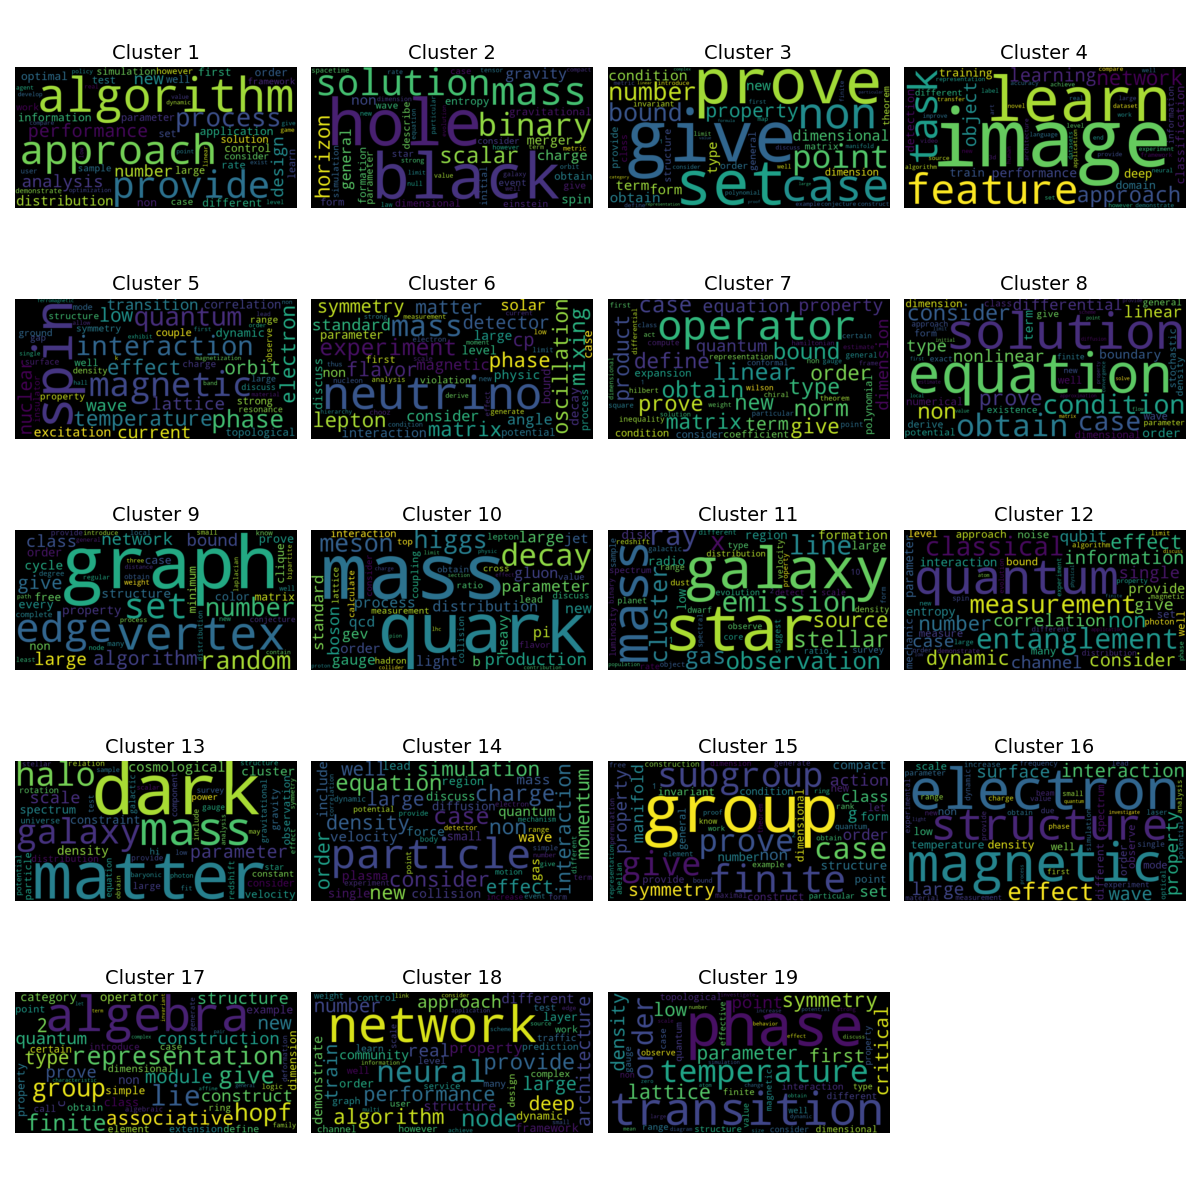

In [38]:
plot_word_clouds(clustered_abstracts_top50)

### 3D Scatterplot Visualization

Another way to visualize our clusters is to obtain a labeled scatterplot of the data. However, we have 100 features for each abstract which makes it infeasible to visualize them with a simple plot. A common solution is to further reduce the dimensionality of the features to 3 or 2 dimensions for plotting. `sklearn.decomposition.PCA` is a class that implements Principal Components Analysis using Singular-Value Decomposition to identify and retain important feature components that cause the most variation in the data (A stack exchange answer about how it is different from `TruncatedSVD` [here](https://stats.stackexchange.com/a/239537)). Let's import the `PCA` class from `sklearn`:

In [39]:
from sklearn.decomposition import PCA

We will now use PCA to reduce the dimensionality of our feature matrix further down to 3 features and use them to produce a [3D scatter plot](https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html) figure. You will need to obtain labels for each abstract using the `KMeans` instance of the best clustering model obtained above and use it to assign colors to each point, and also use `processed_abstracts` to obtain the top 5 most frequent words in each cluster to use them as labels that will appear in the legend.

Fill in the function `clusters_3d_scatterplot()` below that takes as argument the abstracts feature matrix, the `KMeans` instance for the best clustering model we obtained above, a dataframe containing our abstracts in a column named `abstract`, and creates a scatter plot of the data in 3D with each point colored distinctly based on its assigned cluster.

**Note**: Set `figsize=[15,15]` and `cmap="turbo"` while plotting the figure. X,Y, and Z limits should be `[-0.18, +0.18]`, and location for the legend should be `loc="outside center right"`. Other features of the plot should be understood from the figure above.

To make the plot interactive, we need to install the package `ipympl` and set the macro `widget` before proceeding:

In [41]:
# %pip install ipympl
# %matplotlib widget

In [42]:
def clusters_3d_scatterplot(abstracts_feats:np.ndarray, clustering:KMeans, abstracts:pd.DataFrame):
    """
    Generate a 3D Scatterplot of the best K-Means clustering
    model using PCA

    Parameters
    ----------
    abstracts_feats : np.ndarray
        Feature matrix for abstracts data
    clustering:KMeans
        Instance of KMeans class
    abstracts:pd.DataFrame
        Dataframe containing a column
        'abstract'
    """


    # Step 1: Reduce dimensions with PCA
    pca = PCA(n_components=3)
    reduced_feats = pca.fit_transform(abstracts_feats)
    
    # Step 2: Get cluster labels
    labels = clustering.labels_
    
    # Step 3: Get top 5 words for each cluster for the legend
    top_words_per_cluster = []
    for cluster in range(clustering.n_clusters):
        cluster_abstracts = abstracts['abstract'][labels == cluster]
        words = [word for abstract in cluster_abstracts for word in abstract]
        word_freq = {}
        for word in words:
            word_freq[word] = word_freq.get(word, 0) + 1
        sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
        top_words = [word[0] for word in sorted_words[:5]]
        top_words_per_cluster.append(", ".join(top_words))
    
    # Step 4: Create a 3D scatter plot
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot with cluster-specific colors
    scatter = ax.scatter(
        reduced_feats[:, 0], 
        reduced_feats[:, 1], 
        reduced_feats[:, 2], 
        c=labels, 
        cmap='turbo', 
        s=15
    )
    
    # Set plot limits
    ax.set_xlim([-0.18, 0.18])
    ax.set_ylim([-0.18, 0.18])
    ax.set_zlim([-0.18, 0.18])
    
    # Label axes
    ax.set_xlabel("PCA Feature 1")
    ax.set_ylabel("PCA Feature 2")
    ax.set_zlabel("PCA Feature 3")
    
    # Add legend with cluster topics
    legend_labels = [f"Cluster {i + 1} with topics: {words}" for i, words in enumerate(top_words_per_cluster)]
    ax.legend(
        handles=scatter.legend_elements()[0], 
        labels=legend_labels, 
        loc="center right", 
        bbox_to_anchor=(1.05, 1), 
        title="Clusters"
    )
    
    # Set title
    plt.title("KMeans Clustering 3D Plot")
    plt.tight_layout()
    plt.show()

Let's visualize our scatter plot:

C:\Users\mnusa\AppData\Local\Temp\ipykernel_7316\2273400389.py:63: UserWarning: Mismatched number of handles and labels: len(handles) = 10 len(labels) = 19
  ax.legend(


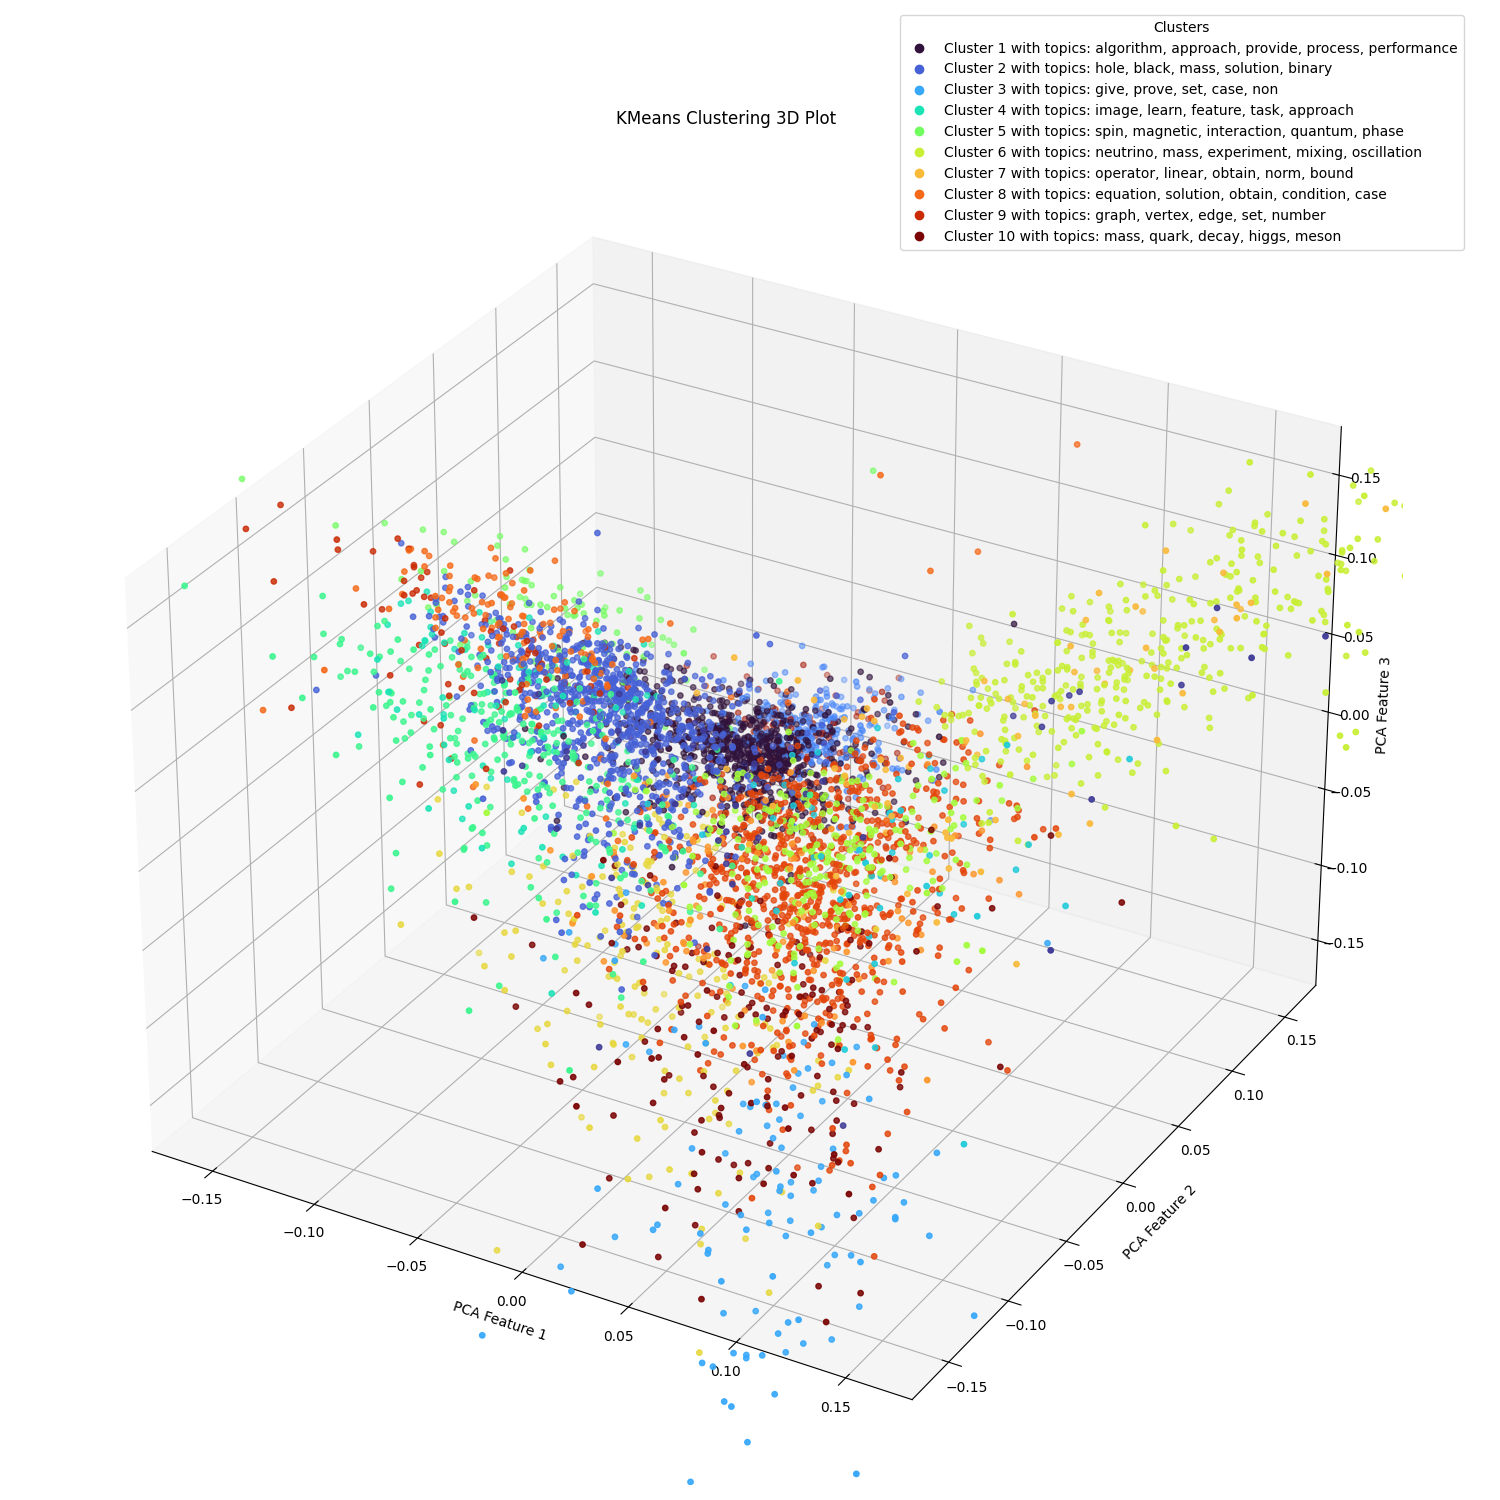

In [43]:
clusters_3d_scatterplot(red_tfidf_feats, best_tfidf_clustering, processed_abstracts)



## E. Findings: Answering Key Questions


**Based on the generated word clouds, are you able to deduce what major scientific topics are prevalent in the data?**

Yes, based on the generated word clouds the major scientific topics in the dataset can be deduced by looking at the prominent terms in each cluster found in the legend. For example, Cluster 1 focuses on machine learning and computational science, with terms like "algorithm," "performance," and "process.", cluster 2 appears to foucs on mathematical modeling and equations, with terms like "equation," "solution," and "condition.", etc. These clusters provide a very good indication of what scientific topics are prevalent in the data. The dataset appears to cover a wide range of scientific topics, including machine learning, mathematics, physics, and astronomy.

**Based on the scatter plot and the word clouds, what do you make of the effectiveness of K-Means to model topics in ArXiv paper submissions using TF-IDF features? Are there any alternatives to TF-IDF that might work better here?**


Based on the scatter plot and word clouds, the effectiveness of K-Means in modeling topics in ArXiv paper submissions using TF-IDF features definitly appears to be reasonably effective, because the scatter plot does give us insight and demonstrates distinct clusters with limited overlap. This helps us conclude certain relationships or trends about the data, ie. the abstracts are being grouped based on meaningful patterns in the TF-IDF features. However, this doesnt mean it is perfect, as some overlap between clusters does suggest limitations, especially for interdisciplinary topics or abstracts that share common terminology across their disciplines (like "network" which could be both graph theory and neural networks).

TF-IDF is definitly a strong baseline for feature representation, but possibly word embeddings, like Word2Vec or GloVe, could better capture the relationships where common terminology is shared between disciplines, which would allow for more nuanced clustering and extraction of the deeper trends within the data. Other options include Document embeddings (Doc2Vec or Sentence-BERT, could also provide a better representation of the abstracts by encoding their overall context), Transformer-based models (BERT or SciBERT, specifically fine-tuned on scientific text, would capture semantics more clearly) or even non-linear clustering methods like DBSCAN or Spectral Clustering. These could all possibly model the more complex relationships in the data and reduce the cluster overlap even more. In conclusion, while K-Means and TF-IDF definitly offer a very solid starting point, using other more advanced representations and clustering techniques could work better for topic modeling for ArXiv abstracts.